# AEMET Data Quality — Proyecto de Calidad de Datos Meteorológicos

Este proyecto demuestra un flujo de trabajo de **calidad de datos** aplicable a estaciones meteorológicas, usando Python.

Incluye:
- Limpieza y tratamiento de valores nulos
- Detección de *outliers* estadísticos (*z-score*)
- Validación contra límites físicos
- Cálculo de KPIs clave
- Detección de *sensor drift* con media móvil
- Visualización de series temporales

> Datos simulados a partir de un CSV de ejemplo.


In [12]:
# Hacer visible el código del proyecto al notebook
import os, sys

# Ruta al directorio raíz del proyecto (padre de 'notebooks')
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root in sys.path:", PROJECT_ROOT in sys.path)


Project root in sys.path: True


In [13]:
import pandas as pd
from src.data_utils import (
    load_sample_csv, remove_duplicates, handle_missing,
    detect_outliers_zscore, compute_kpis
)
from src.quality_checks import flag_physical_limits, flag_sensor_drift
from src.plotting import plot_timeseries

df = load_sample_csv('../data/raw/sample_measurements.csv')
df.head()


,timestamp,station_id,temp,hum,wind,rain
0,2023-01-01 00:00:00,CBA001,14.2,60.5,3.2,0.0
1,2023-01-01 01:00:00,CBA001,13.9,59.8,4.1,0.0
2,2023-01-01 02:00:00,CBA001,13.4,61.1,3.8,0.0
3,2023-01-01 03:00:00,CBA001,80.0,62.0,3.7,0.0
4,2023-01-01 04:00:00,CBA001,NaN,63.2,4.5,0.1


In [14]:
# Eliminar duplicados y tratar valores nulos mediante interpolación
df = remove_duplicates(df)
df = handle_missing(df, method='interpolate')

# Outliers estadísticos (z-score)
df = detect_outliers_zscore(df, cols=['temp','hum','wind','rain'], z=3.0)

# Validación contra límites físicos
df = flag_physical_limits(df)

# Sensor drift con media móvil (ventana corta para el ejemplo)
df = flag_sensor_drift(df, col='temp', window=3, drift_threshold=2.0)

# Ver columnas de banderas
df.filter(like='flag_').head()


,flag_out_temp,flag_out_hum,flag_out_wind,flag_out_rain,flag_phys_temp,flag_phys_hum,flag_phys_wind,flag_phys_rain,flag_drift_temp
0,0,0,0,0,False,False,False,False,0
1,0,0,0,0,False,False,False,False,0
2,0,0,0,0,False,False,False,False,0
3,0,0,0,0,True,False,False,False,1
4,0,0,0,0,False,False,False,False,1


In [15]:
kpis = compute_kpis(df, ['temp','hum','wind','rain'])
import pandas as pd
pd.DataFrame([kpis])


,valid_pct_temp,max_nan_run_temp,valid_pct_hum,max_nan_run_hum,valid_pct_wind,max_nan_run_wind,valid_pct_rain,max_nan_run_rain
0,100.0,0,100.0,0,100.0,0,100.0,0


In [16]:
phys_cols = [c for c in df.columns if c.startswith('flag_phys_')]
drift_cols = [c for c in df.columns if c.startswith('flag_drift_')]
{
    "flags_fisicos": {c: int(df[c].sum()) for c in phys_cols},
    "flags_drift":   {c: int(df[c].sum()) for c in drift_cols}
}


{'flags_fisicos': {'flag_phys_temp': 1,
  'flag_phys_hum': 1,
  'flag_phys_wind': 0,
  'flag_phys_rain': 0},
 'flags_drift': {'flag_drift_temp': 4}}

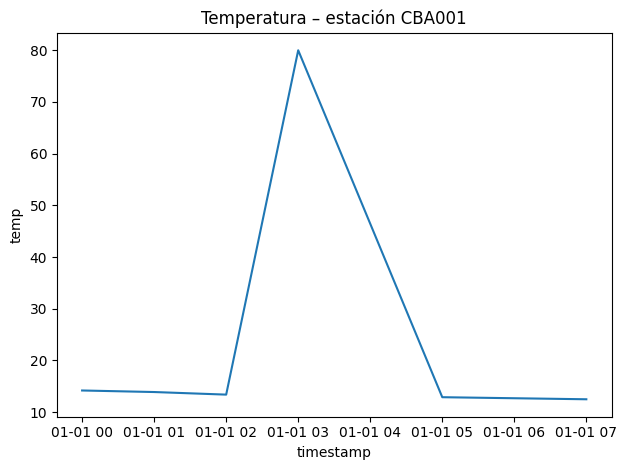

In [17]:
plot_timeseries(df, 'temp', title='Temperatura – estación CBA001')

In [18]:
out_path = os.path.join(PROJECT_ROOT, "data", "processed", "sample_measurements_clean.csv")
df.to_csv(out_path, index=False)
len(df), out_path


(8,
 'c:\\Users\\Marcos\\aemet-data-quality\\data\\processed\\sample_measurements_clean.csv')